In [1]:
import numpy as np
import pandas as pd
import importlib
import data_loader
import gibbs_sampler
importlib.reload(data_loader)
importlib.reload(gibbs_sampler)
from data_loader import CountryDataLoader
from scipy.sparse import block_diag as sparse_block_diag

In [2]:
file_path = r'D:\Bachelor Data\Train'

loader = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="train"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]

loader.load_data(split_date="19321231")  # or 
pre_data = loader.pretrain_dict
train_data = loader.train_dict

X_dict_pre = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.pretrain_dict.items()
}

Y_dict_pre = {
    c: df["y"].to_numpy()
    for c, df in loader.pretrain_dict.items()
}

X_pre = np.vstack([X_dict_pre[c] for c in X_dict_pre])
Y_pre = np.concatenate([Y_dict_pre[c] for c in Y_dict_pre])
Z_pre = sparse_block_diag([X_dict_pre[c] for c in X_dict_pre]).tocsr()


# --- Train data ---
X_dict = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.train_dict.items()
}

Y_dict = {
    c: df["y"].to_numpy()
    for c, df in loader.train_dict.items()
}

X = np.vstack([X_dict[c] for c in X_dict])
Y = np.concatenate([Y_dict[c] for c in Y_dict])
Z = sparse_block_diag([X_dict[c] for c in X_dict]).tocsr()



In [1]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
X_train = X_pre
Y_train = Y_pre

def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-6, 1e2)
    model = Ridge(alpha=alpha, fit_intercept=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_pre):
        X_train, X_val = X_pre[train_idx], X_pre[val_idx]
        Y_train, Y_val = Y_pre[train_idx], Y_pre[val_idx]

        model.fit(X_train, Y_train)
        preds = model.predict(X_val)
        mse = mean_squared_error(Y_val, preds)
        mse_scores.append(mse)

    return np.mean(mse_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
alpha = study.best_params["alpha"]
print("Best alpha:", study.best_params["alpha"])


d:\Bachelor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'X_pre' is not defined

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=alpha,fit_intercept=False)  
ridge.fit(X_pre, Y_pre)

theta_g_ridge = ridge.coef_
residuals = Y_pre - X_pre @ theta_g_ridge

In [4]:

tau_theta_g_sq = np.var(theta_g_ridge) + 1e-2

resid_var = np.var(residuals)
alpha_sigma = 2
beta_sigma = resid_var / alpha_sigma
# Λ_c ~ Gamma(α, β) prior: set α * β = τ²

alpha_lambda = 2
beta_lambda = tau_theta_g_sq / alpha_lambda
# Wishart prior: mean(diag(Sigma)) = τ²
Sigma = tau_theta_g_sq * np.eye(X_pre.shape[1])
nu = X_pre.shape[1] + 2
# 

n_iter = 1000
burn_in = 100


In [5]:
tau_theta_g_sq

np.float64(0.4056907872866972)

In [ ]:
import gibbs_sampler
importlib.reload(gibbs_sampler)
from gibbs_sampler import HierarchicalGibbsSampler

sampler = HierarchicalGibbsSampler(
    X_dict=X_dict,
    Y_dict=Y_dict,
    X=X,
    Y=Y,
    Z=Z,
    n_iter=n_iter,
    burn_in=burn_in,
    tau_theta_g_sq=tau_theta_g_sq,
    alpha_sigma=alpha_sigma,
    beta_sigma=beta_sigma,
    hyper_type="gamma",  # or "gamma"
    alpha_lambda=alpha_lambda,
    beta_lambda=beta_lambda,
    Sigma=Sigma,
    nu=nu
)

sampler.run()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:08<?, ?it/s]


AttributeError: 'HierarchicalGibbsSampler' object has no attribute 'Lambda'

In [ ]:
import importlib
import gibbs_sampler
importlib.reload(gibbs_sampler)
from gibbs_sampler import PosteriorAnalyzer

post_analyzer = PosteriorAnalyzer(
    theta_g_path="theta_g_samples.parquet",
    theta_l_path="theta_l_samples.parquet",
    gc_path="Gc_trace.parquet",
    burn_in=burn_in
)

theta_g_samples = post_analyzer.get_theta_g_samples()

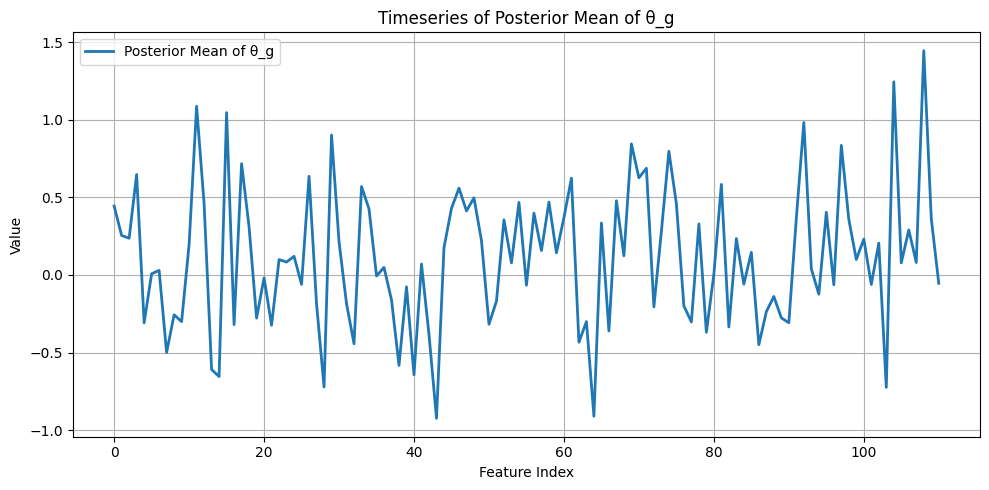

In [2]:
post_analyzer.plot_timeseries("theta_g")

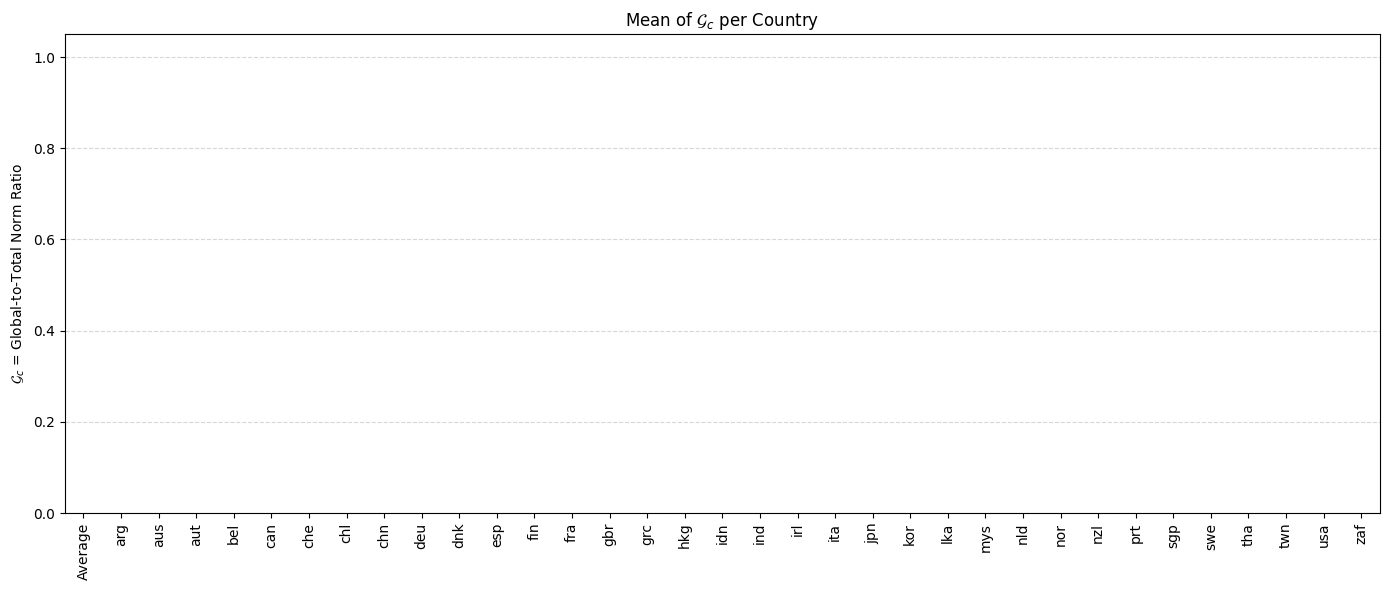

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get Gc means
Gc_mean = post_analyzer.get_Gc_posterior_mean()
Gc_mean["Average"] = np.mean([v for k, v in Gc_mean.items() if k != "Average"])

# Reorder: put 'Average' first, then the rest sorted descending
sorted_keys = ["Average"] + sorted([k for k in Gc_mean if k != "Average"], key=lambda x: Gc_mean[x], reverse=True)
Gc_mean_ordered = pd.Series({k: Gc_mean[k] for k in sorted_keys})

# Plot
Gc_mean_ordered.plot(kind="bar", figsize=(14, 6))
plt.title("Mean of $\\mathcal{G}_c$ per Country")
plt.ylabel("$\\mathcal{G}_c$ = Global-to-Total Norm Ratio")
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




In [7]:
file_path = 'D:/Bachelor Data/Test'

loader_predict = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="test"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]

loader_predict.load_data(split_date=None)

X_test = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader_predict.data_dict.items()
}

Y_test = {
    c: df["y"].to_numpy()
    for c, df in loader_predict.data_dict.items()
}


In [8]:
from sklearn.metrics import r2_score
import numpy as np

theta_g = post_analyzer.get_theta_g_mean()
theta_l = post_analyzer.get_theta_l_mean()

y_true_all = []
y_pred_all = []

for c in X_test:
    X_c = X_test[c]
    y_c = Y_test[c]

    if c not in theta_l:
        continue  # skip countries not in training set

    theta_total = theta_g + theta_l[c]
    y_pred = X_c @ theta_total

    y_true_all.append(y_c)
    y_pred_all.append(y_pred)

y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)

print("$R^2" ,r2_score(y_true,y_pred)*100,"%")

$R^2 -118.35037079137135 %


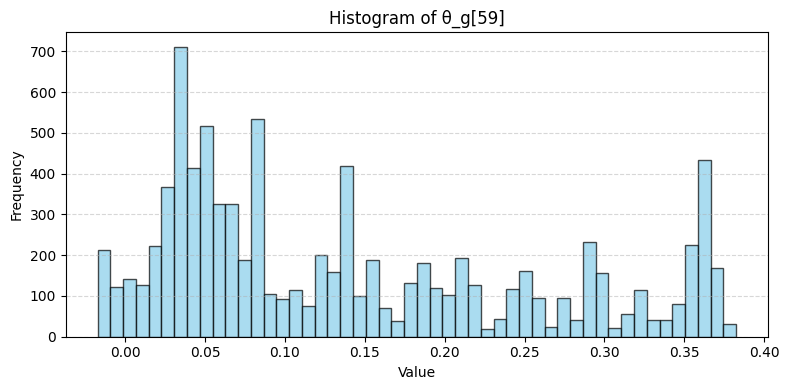

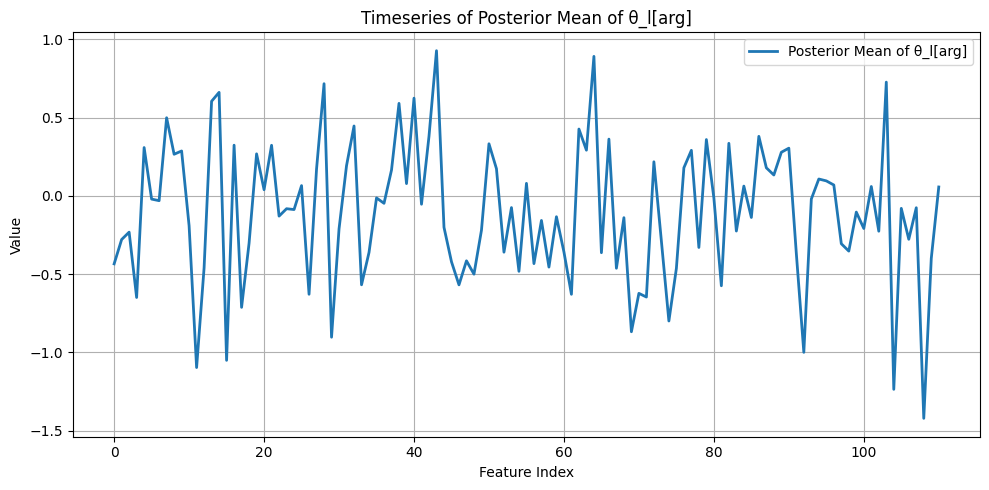

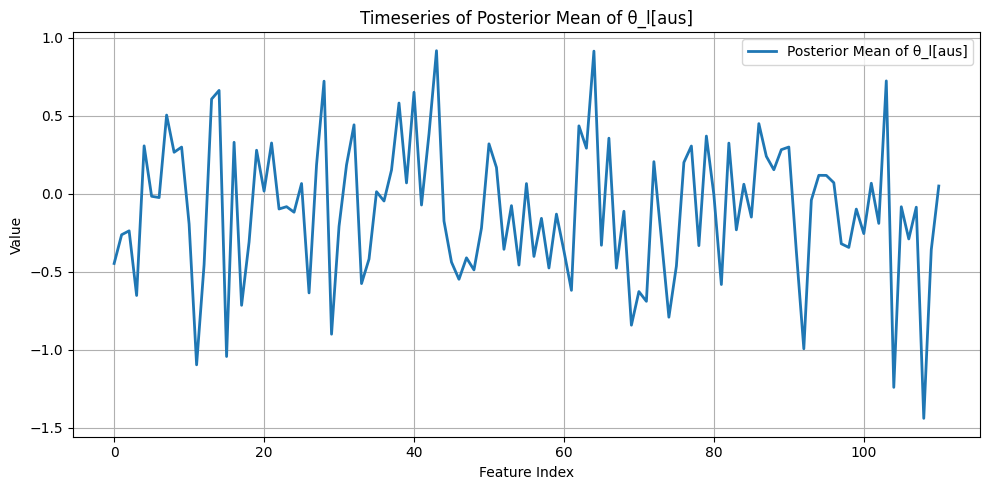

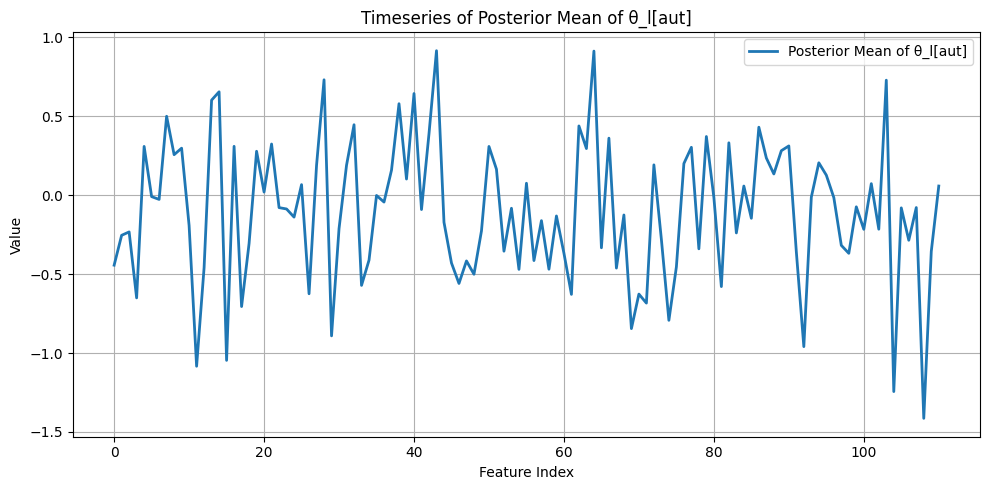

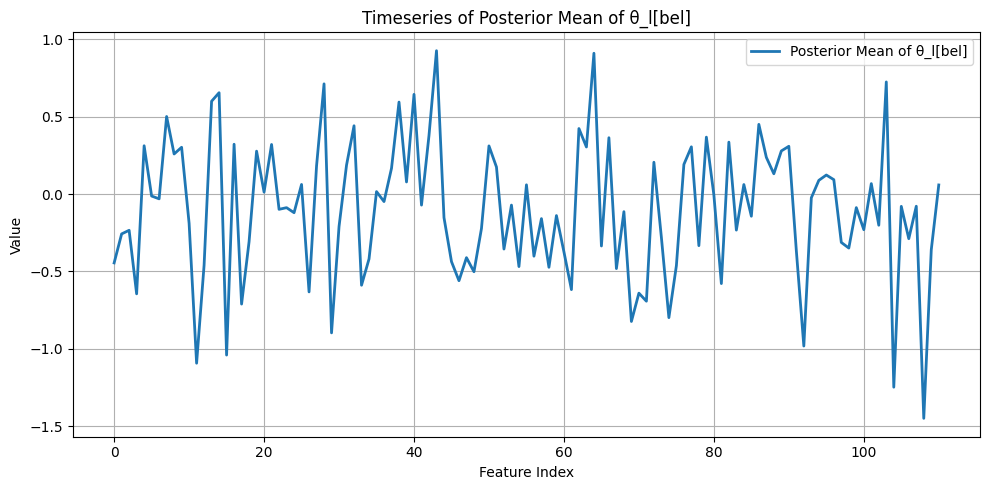

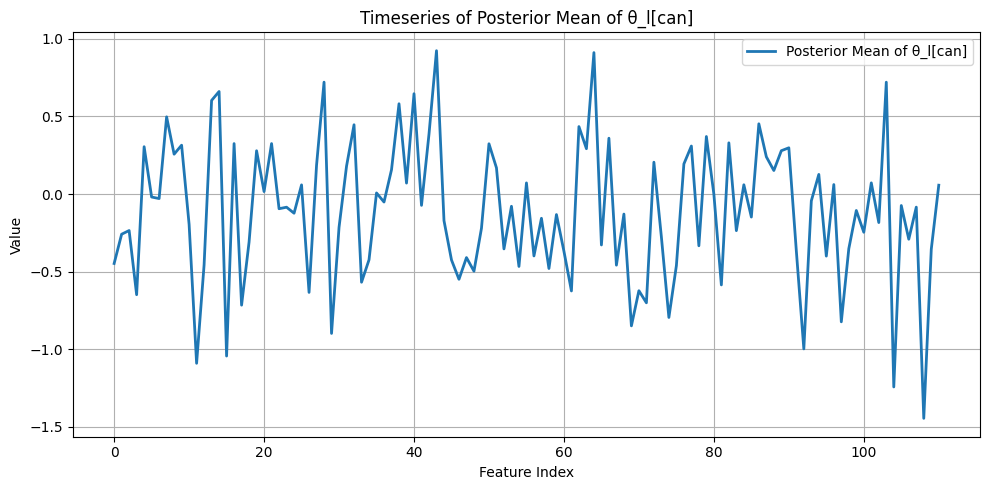

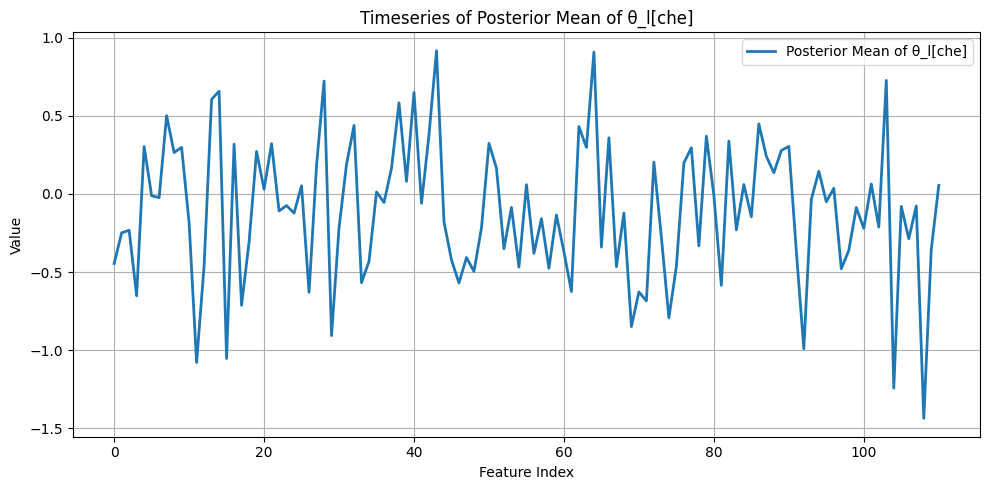

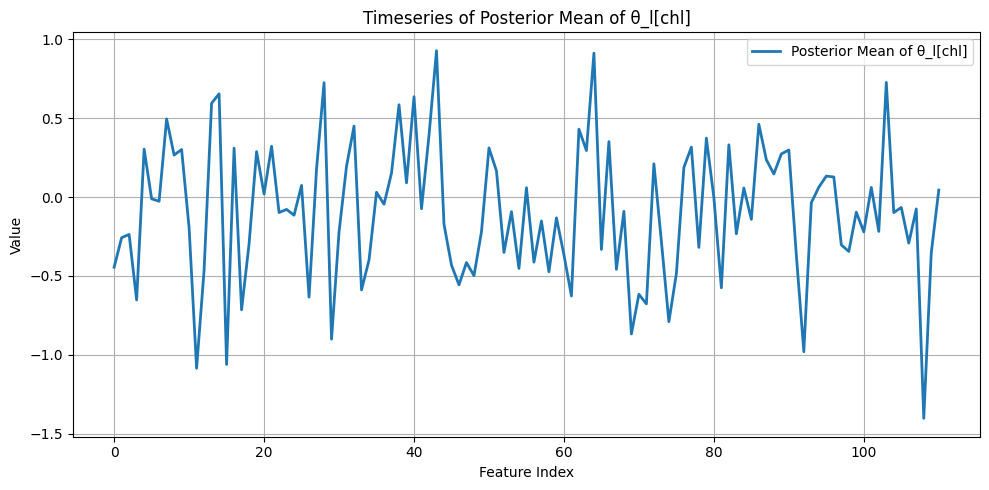

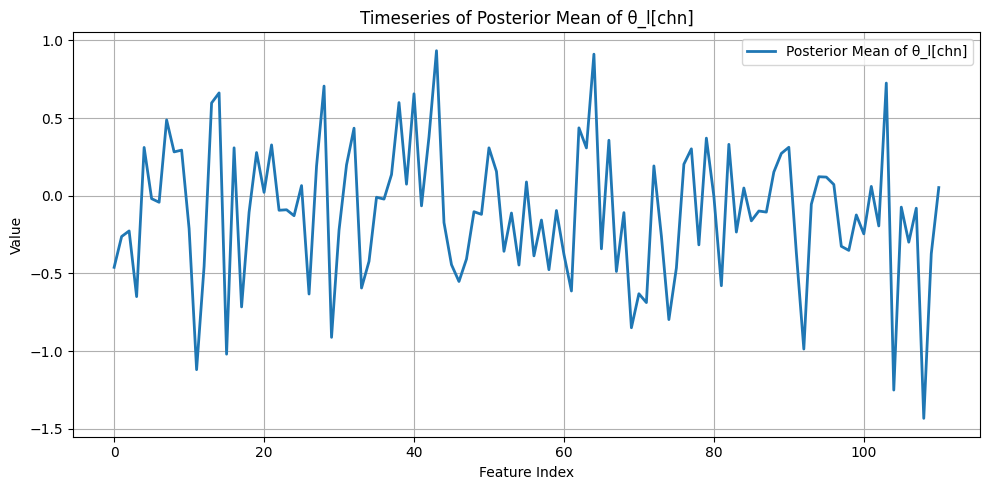

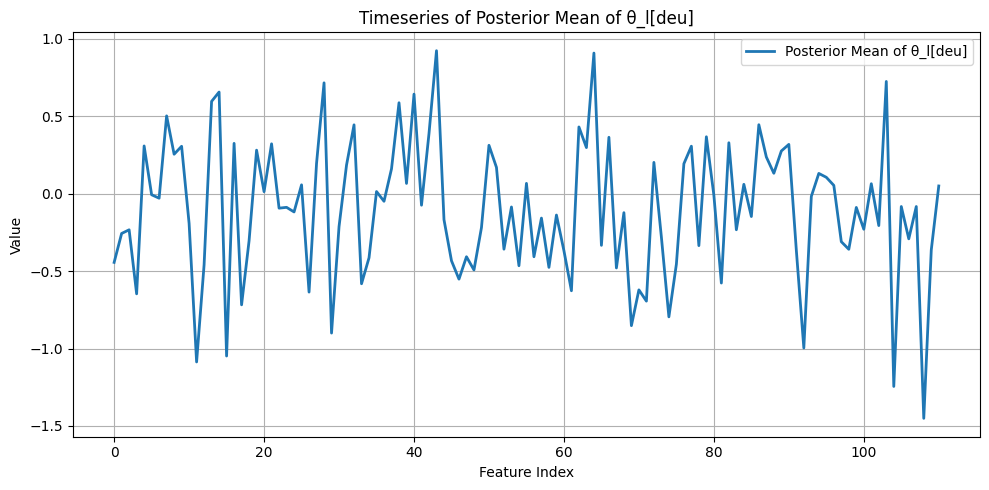

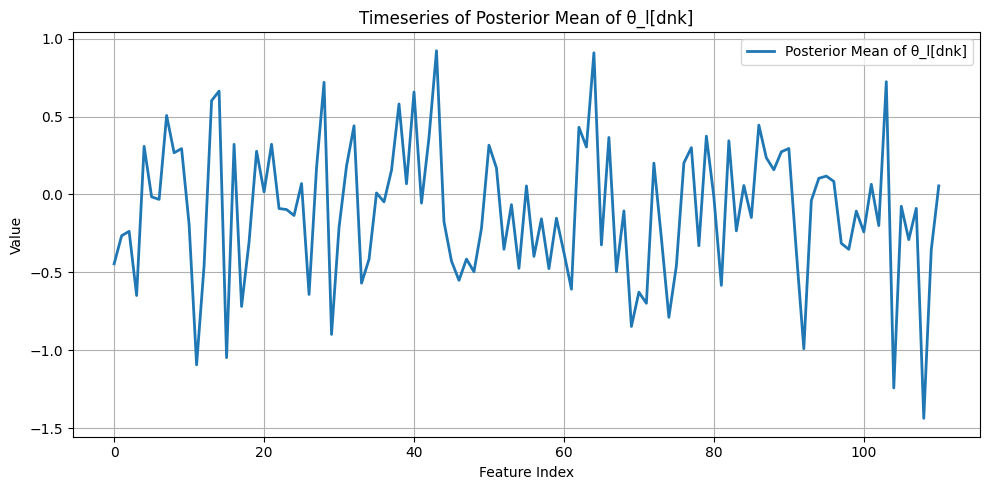

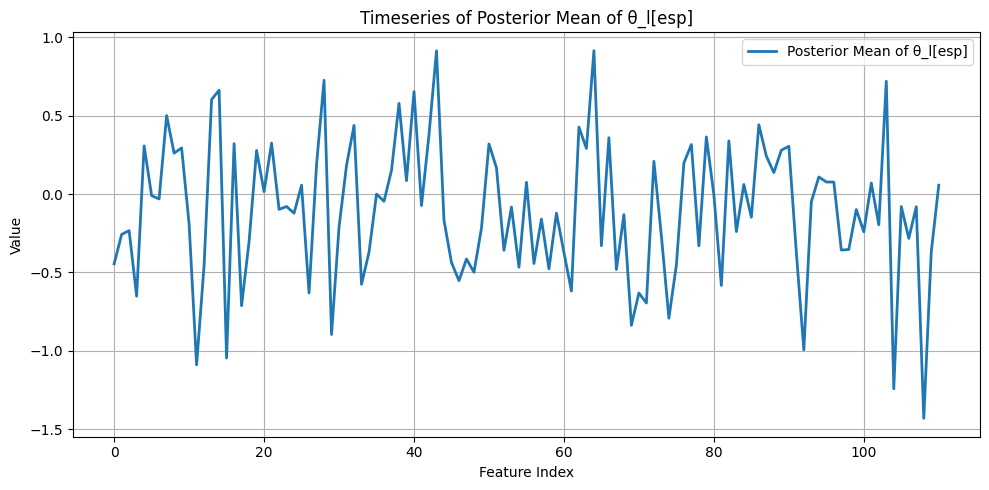

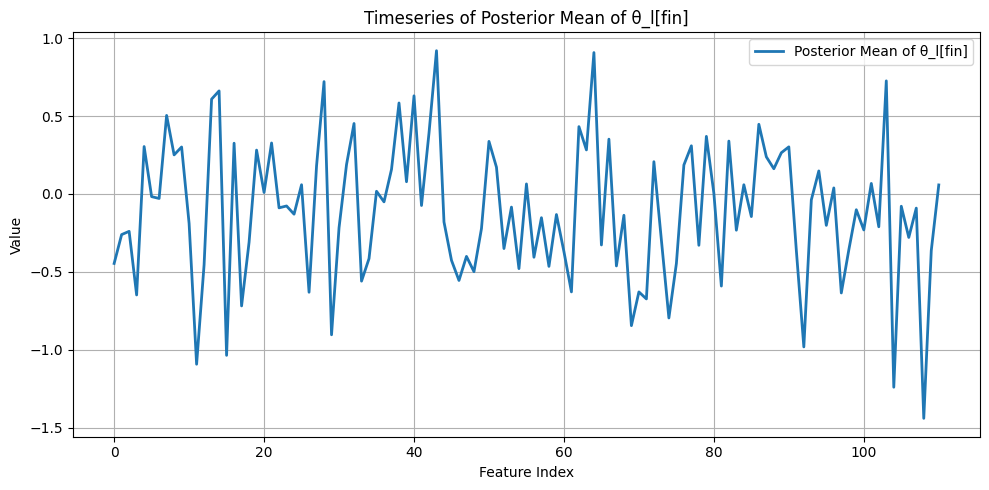

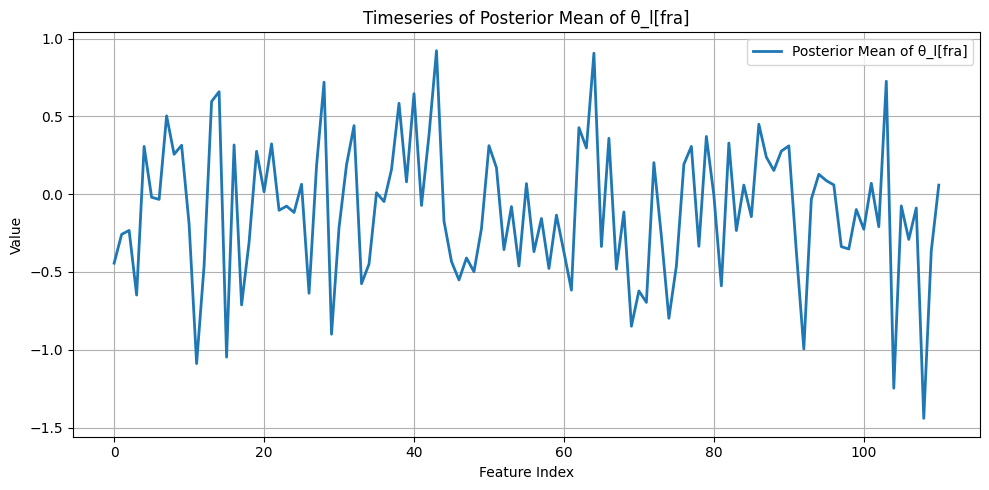

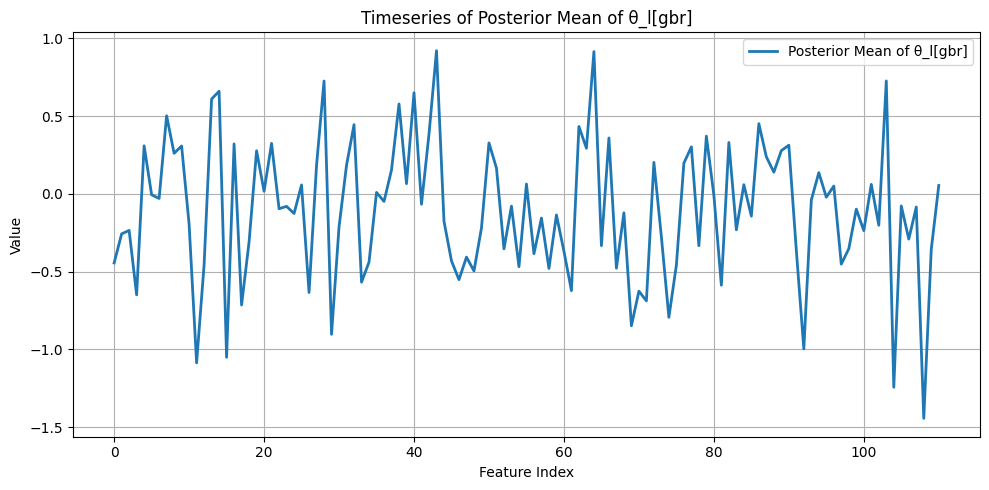

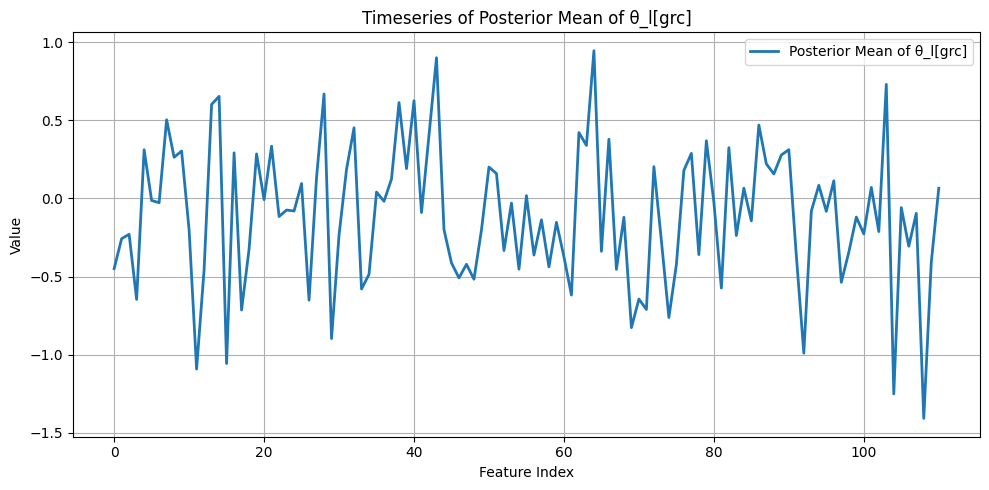

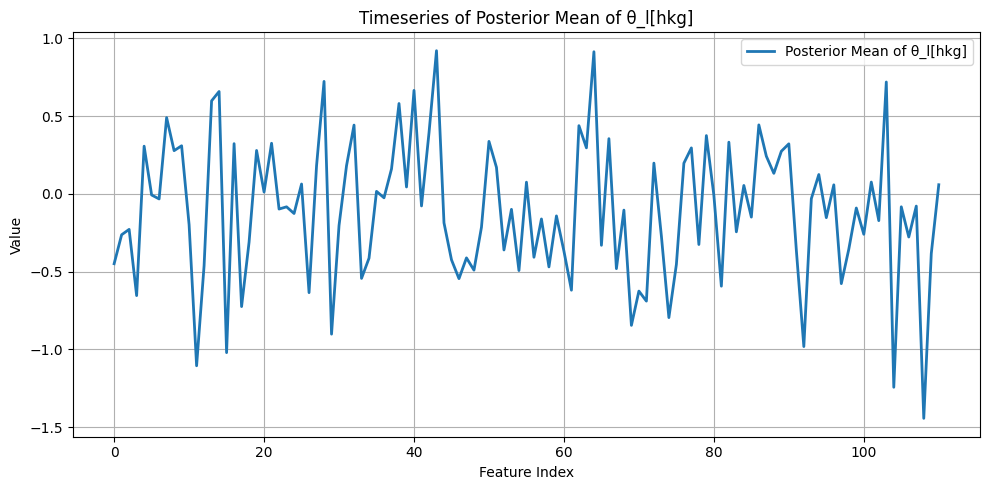

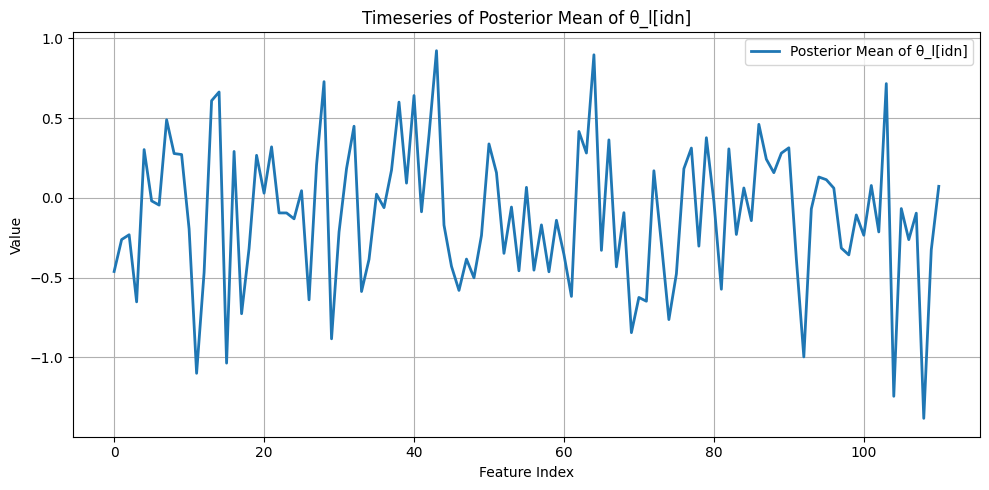

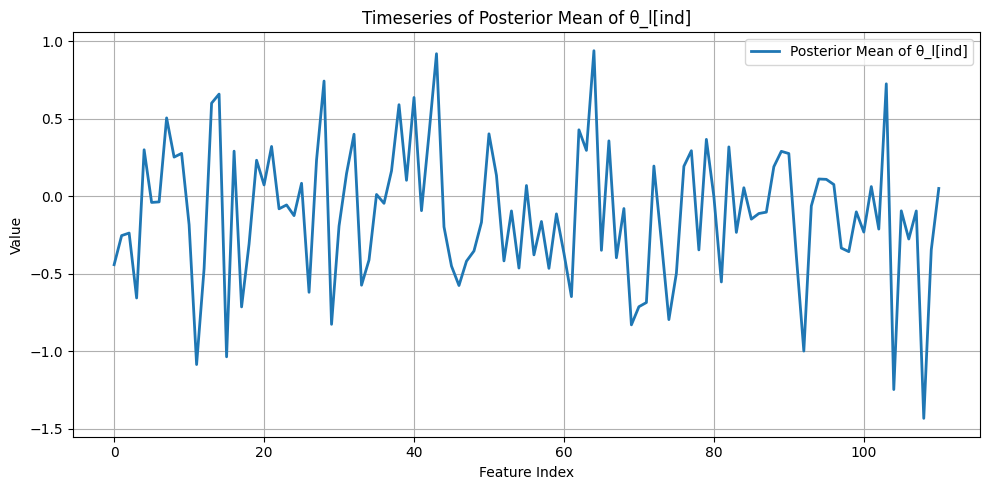

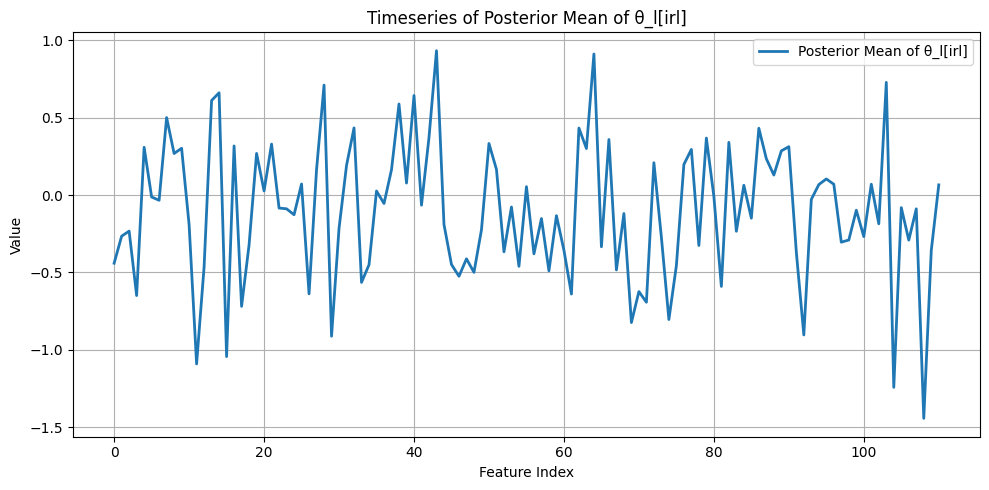

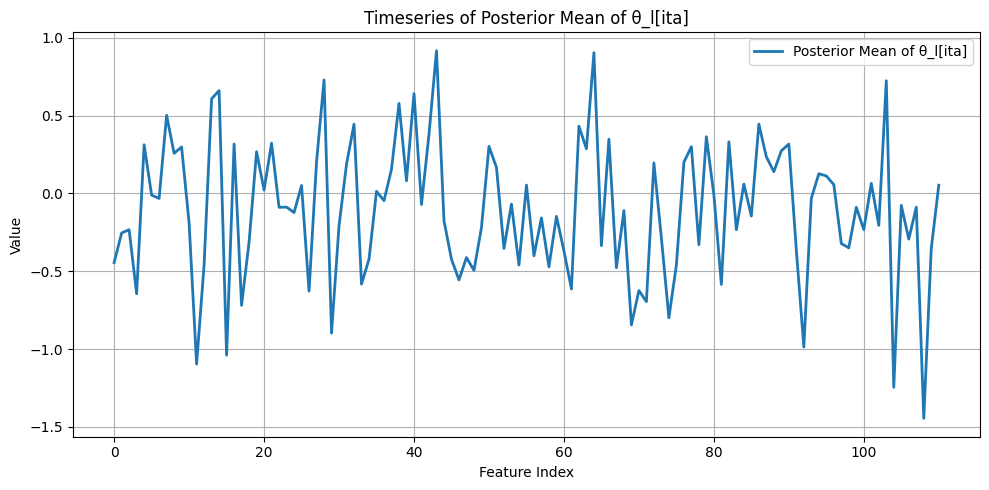

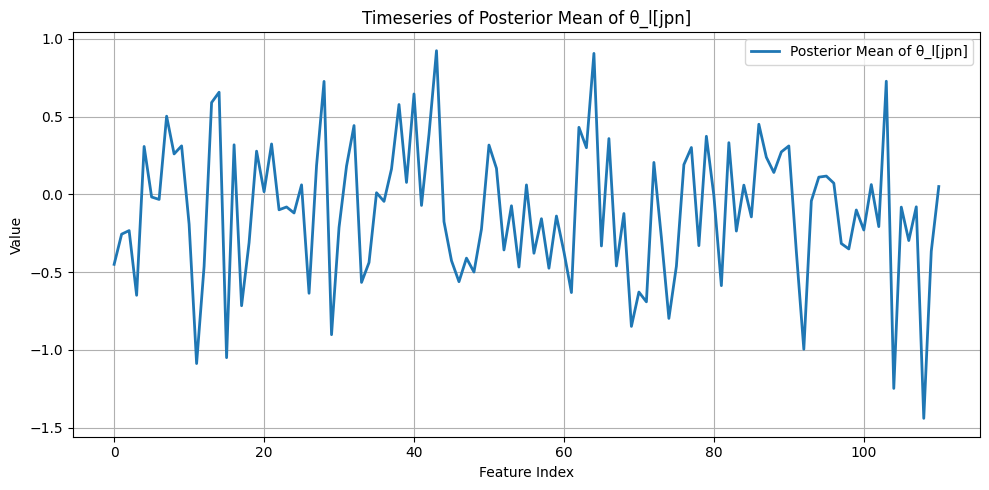

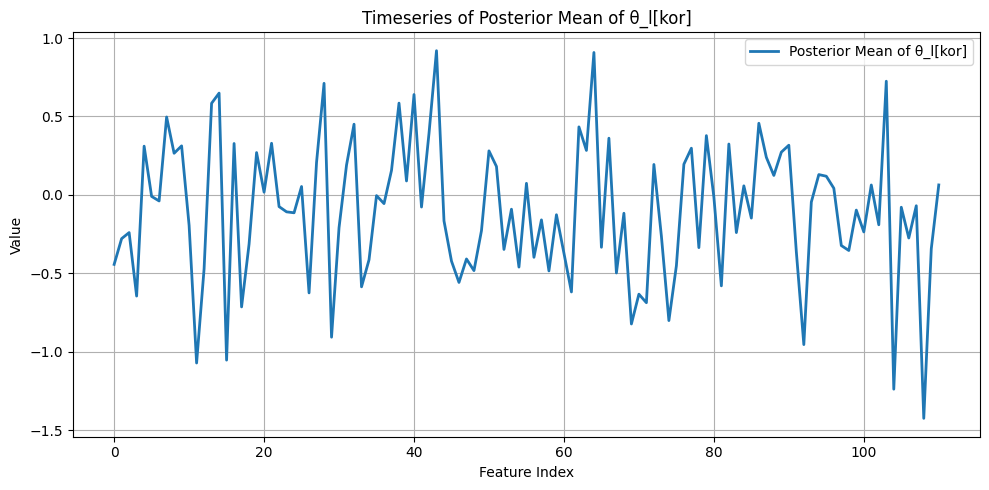

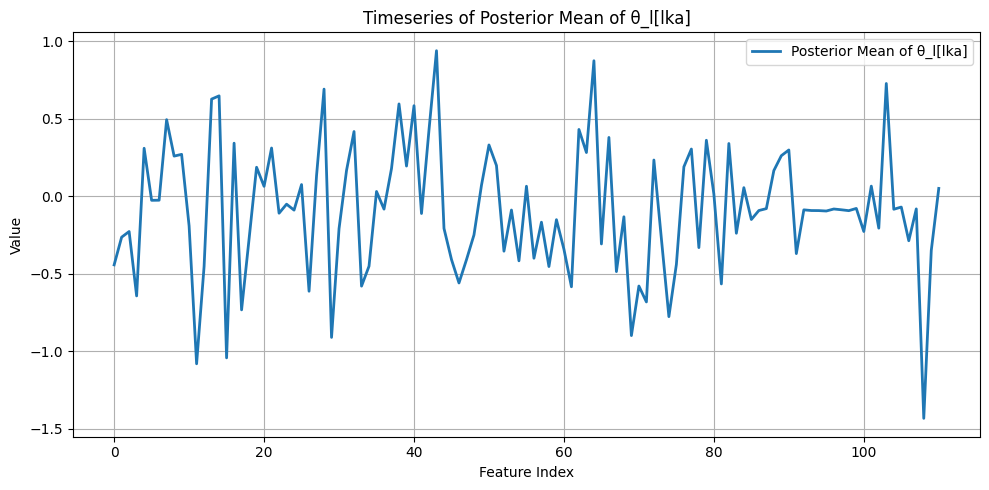

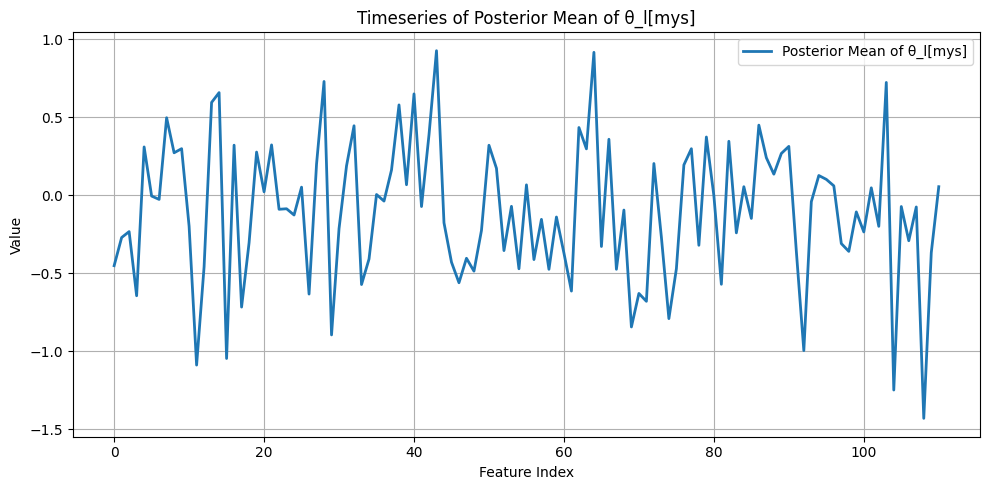

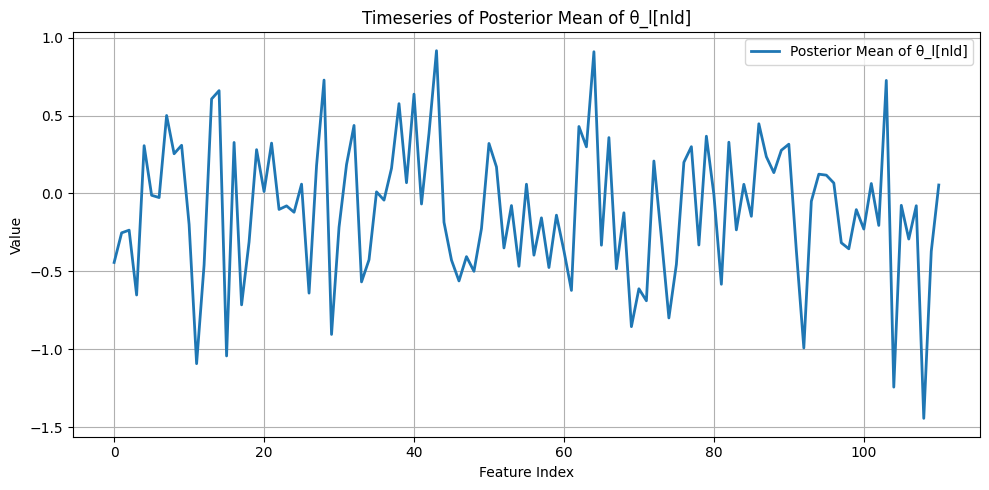

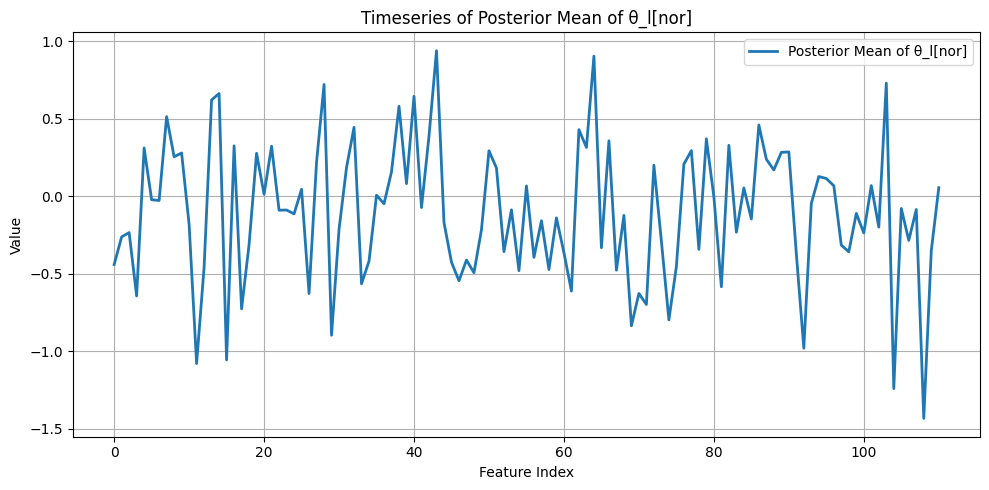

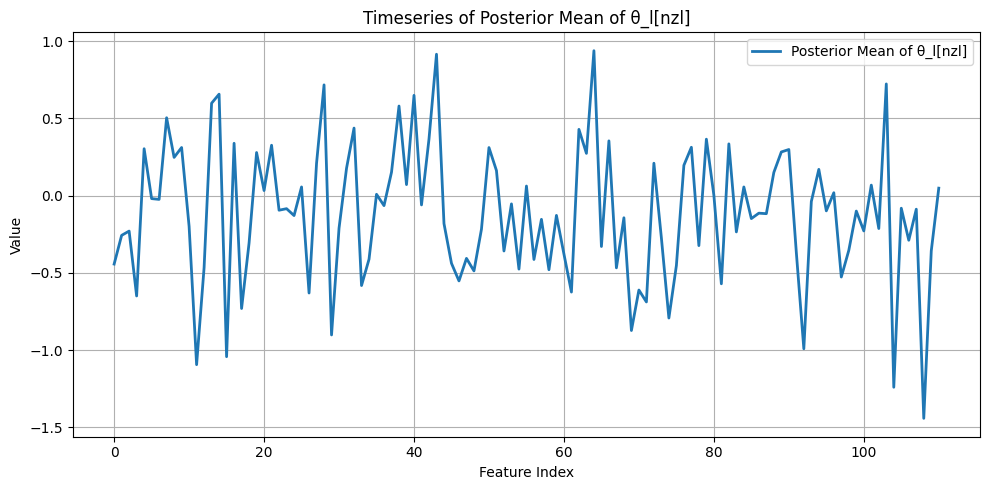

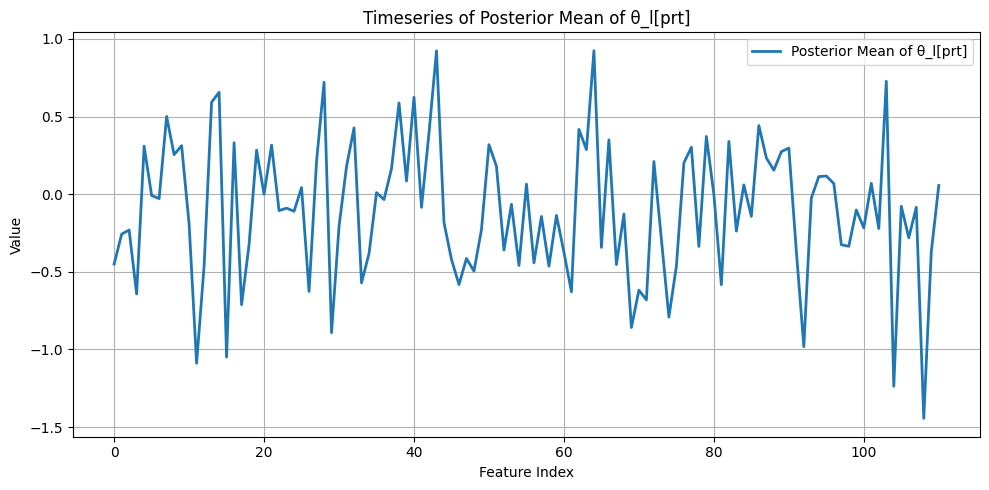

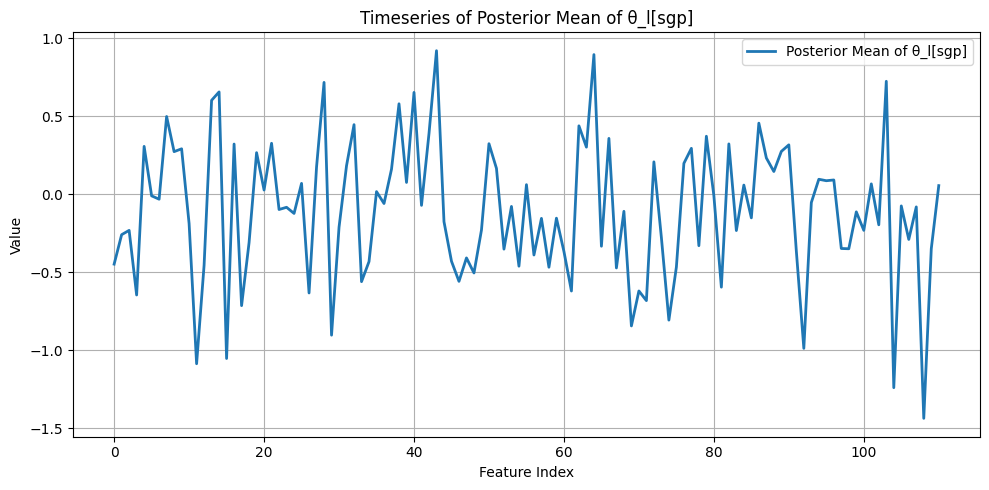

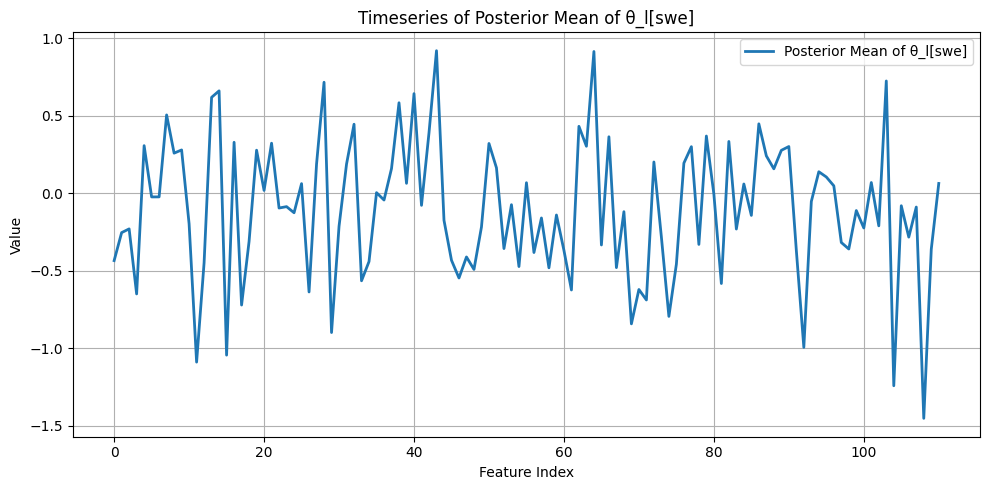

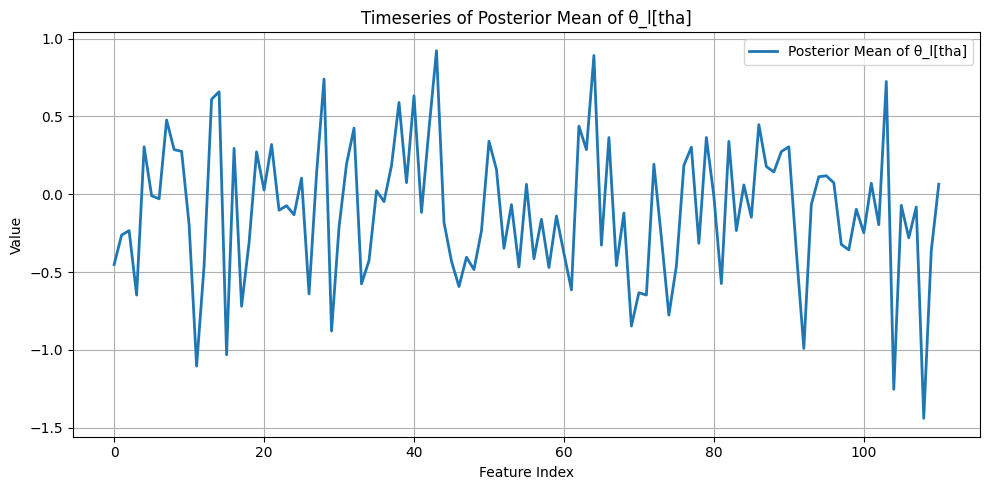

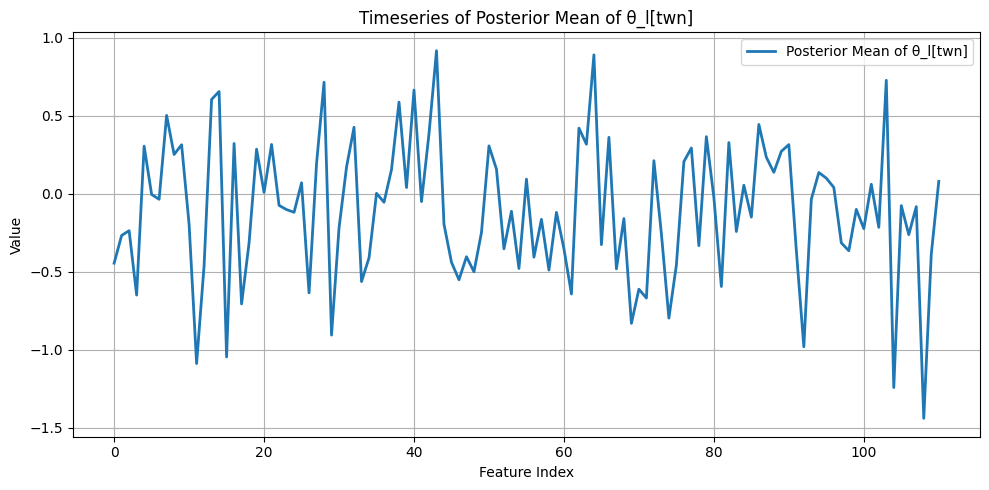

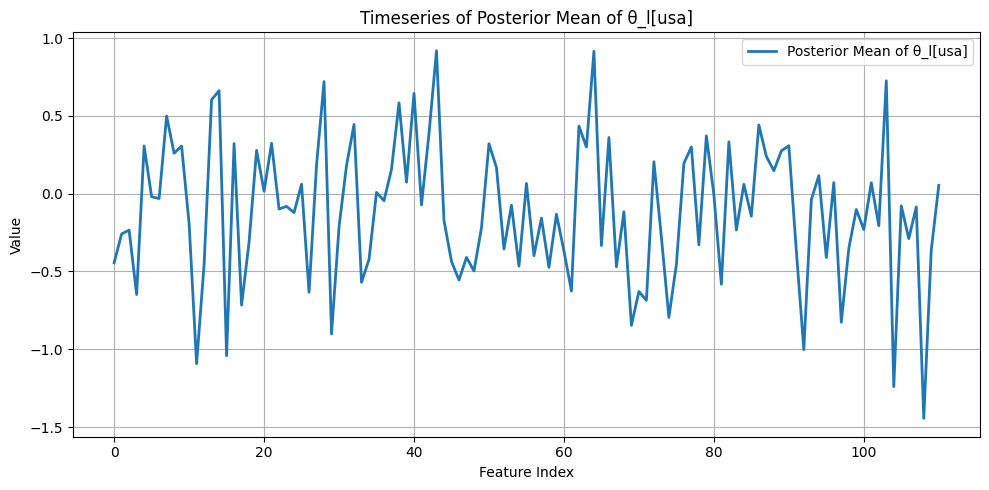

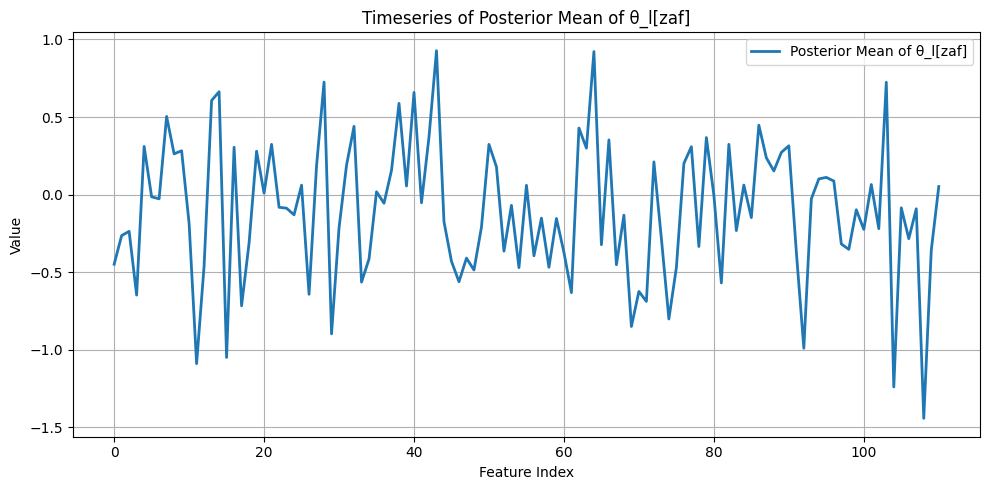

In [9]:
post_analyzer.plot_histogram("theta_g",59)

for c in X_test:
    post_analyzer.plot_timeseries("theta_l",c)